In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import Dependencies

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import random
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# Define dataset path
input_path = "../input/style-color-images/"
print(input_path)

../input/style-color-images/


In [4]:
os.listdir(input_path)

['StyleColorImages.h5', 'style', 'zip_styles']

In [5]:
style_path = os.path.join(input_path, "style")
zip_style_path = os.path.join(input_path, "zip_styles")
h5_path = os.path.join(input_path,"StyleColorImages.h5")

In [6]:
style_path

'../input/style-color-images/style'

In [7]:
# Print number of files in each directory

style_img_path = [os.path.join(style_path, s) for s in os.listdir(style_path) if os.path.isfile(os.path.join(style_path, s))]
zip_style_img_path = [os.path.join(zip_style_path, z) for z in os.listdir(zip_style_path) if os.path.isfile(os.path.join(zip_style_path, z))]

print("Number of images in style directory :", len(style_img_path))
print("Number of images in zip-style directory :", len(zip_style_img_path))

Number of images in style directory : 2186
Number of images in zip-style directory : 2184


# EDA

In [8]:
# Lets print some images
random_show = 4
random_paths = np.random.choice(style_img_path, size=random_show, replace=False).tolist()

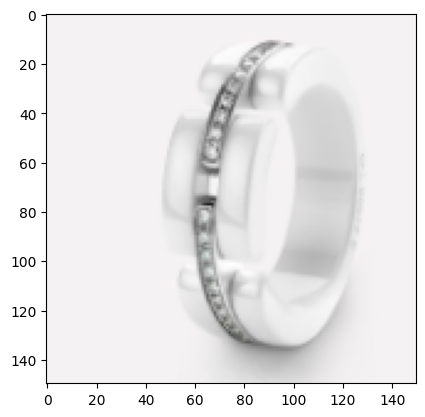

Image Size (width, height): (150, 150)


In [9]:
img = load_img(zip_style_img_path[1])
img_size = img.size
plt.imshow(img)
plt.show()
print("Image Size (width, height):", img_size)

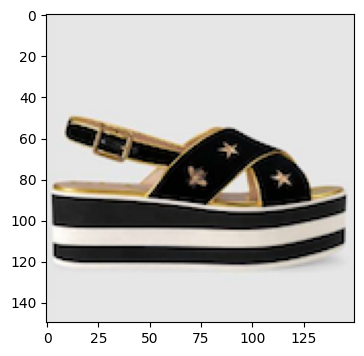

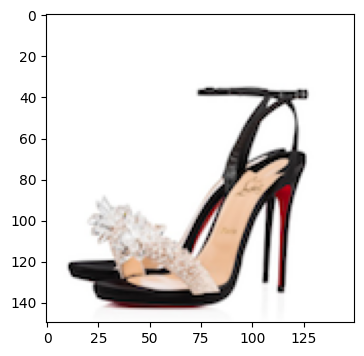

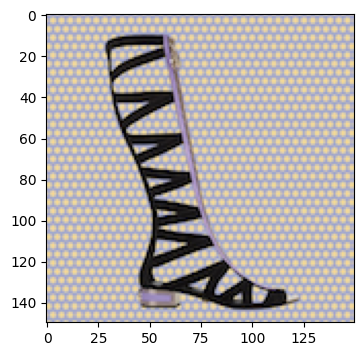

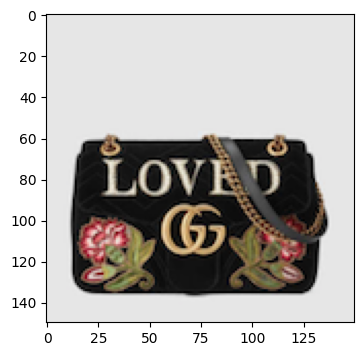

In [10]:
for i in random_paths:
    plt.figure(figsize=(4,4))
    img = load_img(i)
    plt.imshow(img)
    plt.show()

# FEATURE EXTRACTION

In [11]:
## Use resnet50 with pretrained weights from imagenet as feature extractor
## By removing the last softmax layer and taking avg_pool layer as the last

resnet50_imgnet = ResNet50(weights='imagenet')
# Get the last layer
last_layer = resnet50_imgnet.get_layer('avg_pool')

# Info about the first layer
first_layer = resnet50_imgnet.layers[0]
print("First Layer Name:", first_layer.name)
print("First Layer Input Shape:", first_layer.input_shape)

# Info about the last layer
print("Last Layer Name:", last_layer.name)
print("Last Layer Output Shape:", last_layer.output_shape)

feature_extractor = Model(inputs=resnet50_imgnet.input, outputs=last_layer.output)
#feature_extractor.summary()

102967424/102967424 [==============================] - 3s 0us/step
First Layer Name: input_1
First Layer Input Shape: [(None, 224, 224, 3)]
Last Layer Name: avg_pool
Last Layer Output Shape: (None, 2048)


In [12]:
## Input single image to CNN to extract features
#plt.figure(figsize=(4,4))
img = load_img(random_paths[0], target_size=(224,224))
#plt.imshow(img)
#plt.show()

# Convert image into array for input
img_np = img_to_array(img)

# Add dummy dimension to make it as a batch
img_np_batch = np.expand_dims(img_np, axis=0)
print("Shape of single image batch", img_np_batch.shape)

img_np_pp = preprocess_input(img_np_batch.copy());
img_features = feature_extractor.predict(img_np_pp);
print("Features successfully extracted!")
print("Number of image features:",img_features.size)
img_features

Shape of single image batch (1, 224, 224, 3)
1/1 [==============================] - 1s 1s/step
Features successfully extracted!
Number of image features: 2048


array([[0.07914767, 0.        , 0.02428401, ..., 0.08748671, 0.09661788,
        0.1489929 ]], dtype=float32)

In [13]:
img_features.shape

(1, 2048)

In [14]:
style_path

'../input/style-color-images/style'

In [15]:
img_features.shape

(1, 2048)

In [16]:
# Initialize an array to store the features
all_features = np.zeros((len(style_img_path), 2048))  # Assuming ResNet50 has 2048 features

# Iterate over each image path in the list
print("Features extraction started.")
print("Extracting for image\n")
for i, image_path in enumerate(style_img_path):
    try:# Load and preprocess the image
        img = load_img(image_path, target_size=(224, 224))
        img_np = img_to_array(img)
        img_np_batch = np.expand_dims(img_np, axis=0)
        img_np_pp = preprocess_input(img_np_batch.copy())

        # Extract features and store in the array
        img_features = feature_extractor.predict(img_np_pp, verbose=0)
        #print(i)
        all_features[i, :] = img_features.flatten()
    except Exception as e:
        print(f"Error processing image {i + 1}: {e}")
# Print information about the processing
print("Features successfully extracted for all images")

# Print the shape of the array containing all features
print("Shape of all_features array:", all_features.shape)


Features extraction started.
Extracting for image

Error processing image 1204: cannot identify image file <_io.BytesIO object at 0x7f952633aca0>
Error processing image 1237: cannot identify image file <_io.BytesIO object at 0x7f9525745b70>
Features successfully extracted for all images
Shape of all_features array: (2186, 2048)


# Calculate Cosine Similarities

In [17]:
# compute cosine similarities between images
cos_sim = cosine_similarity(all_features)

# store the results into a pandas dataframe
cos_sim_df = pd.DataFrame(cos_sim, columns=style_img_path, index=style_img_path)
cos_sim_df.head()

,../input/style-color-images/style/4_7_026.png,../input/style-color-images/style/5_0_037.png,../input/style-color-images/style/0_0_083.png,../input/style-color-images/style/6_7_006.png,../input/style-color-images/style/3_8_011.png,../input/style-color-images/style/6_3_003.png,../input/style-color-images/style/2_7_005.png,../input/style-color-images/style/0_2_027.png,../input/style-color-images/style/2_1_031.png,../input/style-color-images/style/4_5_017.png,...,../input/style-color-images/style/4_4_012.png,../input/style-color-images/style/1_1_018.png,../input/style-color-images/style/2_0_018.png,../input/style-color-images/style/6_3_020.png,../input/style-color-images/style/4_4_010.png,../input/style-color-images/style/0_2_014.png,../input/style-color-images/style/3_8_006.png,../input/style-color-images/style/2_2_008.png,../input/style-color-images/style/3_0_031.png,../input/style-color-images/style/1_2_013.png
../input/style-color-images/style/4_7_026.png,1.000000,0.303759,0.236755,0.238010,0.279044,0.281801,0.464180,0.336380,0.309323,0.308258,...,0.548208,0.256790,0.277080,0.257230,0.395934,0.307791,0.375543,0.268879,0.224681,0.499165
../input/style-color-images/style/5_0_037.png,0.303759,1.000000,0.459214,0.380964,0.563072,0.392959,0.355484,0.458104,0.384310,0.359989,...,0.218025,0.254437,0.652995,0.390312,0.301125,0.374960,0.510806,0.422727,0.571227,0.432779
../input/style-color-images/style/0_0_083.png,0.236755,0.459214,1.000000,0.253086,0.415930,0.394367,0.319349,0.345334,0.405177,0.320024,...,0.253152,0.268350,0.453283,0.322390,0.275660,0.351518,0.470386,0.362198,0.494811,0.282470
../input/style-color-images/style/6_7_006.png,0.238010,0.380964,0.253086,1.000000,0.349087,0.522161,0.329390,0.253379,0.321343,0.271178,...,0.182688,0.382889,0.500700,0.317102,0.273813,0.472751,0.281216,0.347912,0.399483,0.398039
../input/style-color-images/style/3_8_011.png,0.279044,0.563072,0.415930,0.349087,1.000000,0.360213,0.361235,0.517085,0.376893,0.433968,...,0.247555,0.259200,0.680166,0.356353,0.285998,0.396247,0.692360,0.428139,0.637452,0.486366


In [18]:
cos_sim_df.to_csv("/kaggle/working/cos_sim.csv")
cos_sim_df.to_pickle("/kaggle/working/cos_sim.pickle")

### Cosine Similarity: Path Clean


In [19]:
# Extract filenames from paths using pathlib
filenames = [Path(path).name for path in style_img_path]

# Create DataFrame with filenames as index and columns
cos_sim_df_clean = pd.DataFrame(cos_sim, columns=filenames, index=filenames)

cos_sim_df_clean.to_csv("/kaggle/working/cos_sim_df_clean.csv")
cos_sim_df_clean.to_pickle("/kaggle/working/cos_sim_df_clean.pickle")

In [20]:
cos_sim_df_clean

,4_7_026.png,5_0_037.png,0_0_083.png,6_7_006.png,3_8_011.png,6_3_003.png,2_7_005.png,0_2_027.png,2_1_031.png,4_5_017.png,...,4_4_012.png,1_1_018.png,2_0_018.png,6_3_020.png,4_4_010.png,0_2_014.png,3_8_006.png,2_2_008.png,3_0_031.png,1_2_013.png
4_7_026.png,1.000000,0.303759,0.236755,0.238010,0.279044,0.281801,0.464180,0.336380,0.309323,0.308258,...,0.548208,0.256790,0.277080,0.257230,0.395934,0.307791,0.375543,0.268879,0.224681,0.499165
5_0_037.png,0.303759,1.000000,0.459214,0.380964,0.563072,0.392959,0.355484,0.458104,0.384310,0.359989,...,0.218025,0.254437,0.652995,0.390312,0.301125,0.374960,0.510806,0.422727,0.571227,0.432779
0_0_083.png,0.236755,0.459214,1.000000,0.253086,0.415930,0.394367,0.319349,0.345334,0.405177,0.320024,...,0.253152,0.268350,0.453283,0.322390,0.275660,0.351518,0.470386,0.362198,0.494811,0.282470
6_7_006.png,0.238010,0.380964,0.253086,1.000000,0.349087,0.522161,0.329390,0.253379,0.321343,0.271178,...,0.182688,0.382889,0.500700,0.317102,0.273813,0.472751,0.281216,0.347912,0.399483,0.398039
3_8_011.png,0.279044,0.563072,0.415930,0.349087,1.000000,0.360213,0.361235,0.517085,0.376893,0.433968,...,0.247555,0.259200,0.680166,0.356353,0.285998,0.396247,0.692360,0.428139,0.637452,0.486366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0_2_014.png,0.307791,0.374960,0.351518,0.472751,0.396247,0.620949,0.332344,0.374914,0.376479,0.309045,...,0.256960,0.367561,0.422930,0.358288,0.345513,1.000000,0.335785,0.430278,0.437203,0.508286
3_8_006.png,0.375543,0.510806,0.470386,0.281216,0.692360,0.360511,0.384854,0.546539,0.410296,0.490042,...,0.306391,0.273620,0.559323,0.345341,0.279703,0.335785,1.000000,0.390705,0.516140,0.524130
2_2_008.png,0.268879,0.422727,0.362198,0.347912,0.428139,0.501696,0.523084,0.347550,0.439231,0.398533,...,0.345880,0.266110,0.446740,0.387400,0.452788,0.430278,0.390705,1.000000,0.479195,0.470934
3_0_031.png,0.224681,0.571227,0.494811,0.399483,0.637452,0.470441,0.385748,0.420356,0.371493,0.327071,...,0.206006,0.270597,0.695811,0.456654,0.309815,0.437203,0.516140,0.479195,1.000000,0.404958


# Retrive the most similar products

In [21]:
# function to retrieve the most similar products for a given one
def retrieve_similar_products(given_img, nb_closest_images=3):

    print("-----------------------------------------------------------------------")
    print("original product:")

    original = load_img(given_img, target_size=(150,150))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("most similar products:")
    
    
    #closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    #closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]
    
    full_path = given_img
    file_name = Path(full_path).name
    closest_imgs = cos_sim_df_clean[file_name].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = cos_sim_df_clean[file_name].sort_values(ascending=False)[1:nb_closest_images+1]
    
    
    for i in range(0,len(closest_imgs)):
        directory_path = "../input/style-color-images/style/"
        full_path =  Path(directory_path) / closest_imgs[i]
        #original = load_img(closest_imgs[i], target_size=(150,150))
        original = load_img(full_path, target_size=(150,150))
        plt.imshow(original)
        plt.show()
        print("similarity score : ",closest_imgs_scores[i])

-----------------------------------------------------------------------
original product:


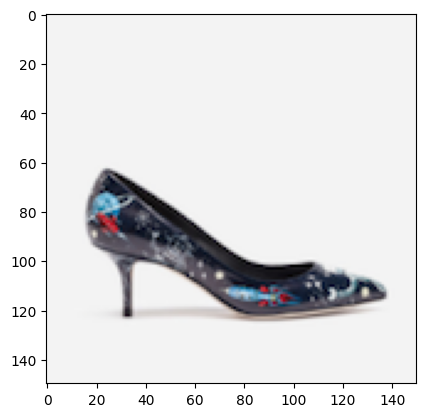

-----------------------------------------------------------------------
most similar products:


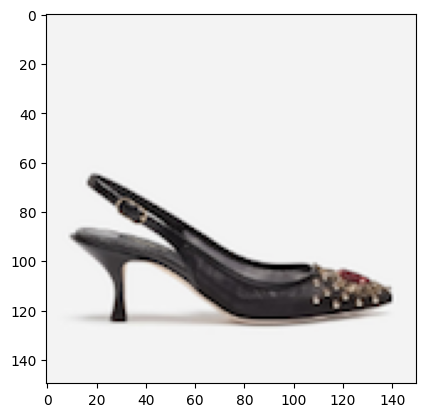

similarity score :  0.8290685148308448


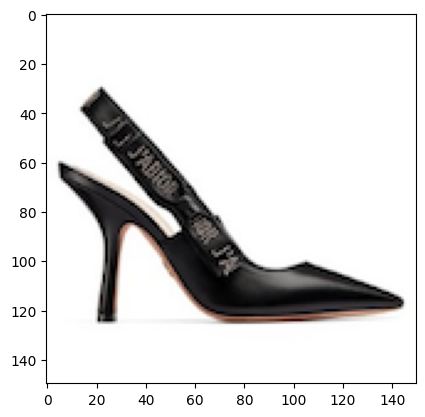

similarity score :  0.7935139645399106


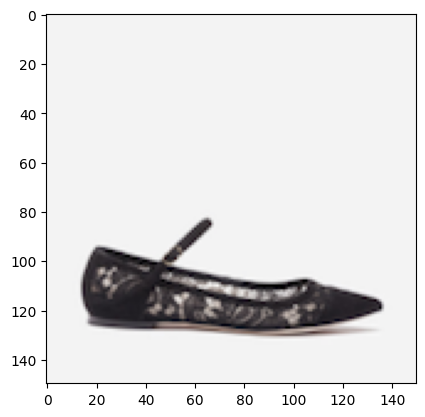

similarity score :  0.7750532252898654


In [22]:
random_int =  random.randint(0, 2185)
retrieve_similar_products(style_img_path[random_int])